In [98]:
import gdown
import h5py
import numpy as np
from tqdm import tqdm  # For progress bar
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from PIL import Image

In [39]:
# Google Drive file URL
#file_id = "1Qe67DEDiPcuzZ_5MH9C-wVPrq1VHyDz8"  # Extracted file ID from your URL
#filename = "Project 1 Specimen 1 Area 2 Site 1 Map Data 11.h5oina"

file_id = "1Qtd9BD_U5W7TxXMVeBNBWXf2IqDzeoTS"  # Extracted file ID from your URL
filename = "Project 1 Specimen 1 Area 2 Site 20 Map Data 30.h5oina"

In [40]:
url = f"https://drive.google.com/uc?id={file_id}"  # Construct direct download link
output = filename

# Download file
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Qtd9BD_U5W7TxXMVeBNBWXf2IqDzeoTS
From (redirected): https://drive.google.com/uc?id=1Qtd9BD_U5W7TxXMVeBNBWXf2IqDzeoTS&confirm=t&uuid=cfc9dbf9-2a55-4b90-95b1-9ae53222b6db
To: /content/Project 1 Specimen 1 Area 2 Site 20 Map Data 30.h5oina
100%|██████████| 230M/230M [00:01<00:00, 181MB/s]


'Project 1 Specimen 1 Area 2 Site 20 Map Data 30.h5oina'

In [41]:
file = h5py.File(output, 'r')

In [42]:
print(list(file.keys()))  # List contents of the file

['1', 'Format Version', 'Index', 'Manufacturer', 'Software Version']


In [43]:
spectrum_Data = file['/1/EDS/Data/Spectrum']
spectrum_Data.size

2952790016

In [44]:
spectrum_Data.shape

(2883584, 1024)

In [45]:
X_Data = file['/1/EDS/Data/X']
X_Data.shape

(2883584,)

In [46]:
Y_Data = file['/1/EDS/Data/Y']
Y_Data.shape

(2883584,)

In [47]:
X_Data[0]

0.0

In [48]:
maxx_micron = X_Data[X_Data.size-1]
maxx_micron

647.18384

In [49]:
scaling_factor = 0.316162  # Microns per pixel

In [50]:
Y_Data[0]

0.0

In [51]:
maxy_micron = Y_Data[Y_Data.size-1]
maxy_micron

444.8401

In [52]:
spectrum_Data[0]

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [53]:
# Determine the grid size
x_pixels = len(np.unique(file['/1/EDS/Data/X']))  # Number of unique X positions
y_pixels = len(np.unique(file['/1/EDS/Data/Y']))  # Number of unique Y positions
spectrum_length = spectrum_Data.shape[1]  # Length of each spectrum
print(f"Grid size: {y_pixels} x {x_pixels} pixels.")
print(f"Spectrum length: {spectrum_length} channels.")

Grid size: 1408 x 2048 pixels.
Spectrum length: 1024 channels.


In [54]:
scaling_factor_x = maxx_micron/x_pixels
scaling_factor_x

0.31600773334503174

In [55]:
scaling_factor_y = maxy_micron/y_pixels
scaling_factor_y

0.3159375624223189

In [56]:
# Open the file and access datasets
print("Opening HDF5 file and preparing for chunked processing...")

spectra_array2 = np.zeros((y_pixels, x_pixels, spectrum_length), dtype=np.uint8)

# Process spectra in chunks
print("Processing spectra in chunks...")
chunk_size = 10000  # Adjust based on your system's memory
for start_idx in tqdm(range(0, spectrum_Data.shape[0], chunk_size), desc="Processing chunks"):
  end_idx = min(start_idx + chunk_size, spectrum_Data.shape[0])
  chunk = spectrum_Data[start_idx:end_idx, :]  # Load chunk into memory

  # Map 1D chunk indices to 2D grid indices
  for flat_idx, spectrum in enumerate(chunk):
    y_idx = (start_idx + flat_idx) // x_pixels
    x_idx = (start_idx + flat_idx) % x_pixels
    spectra_array2[y_idx, x_idx, :] = spectrum

print("Spectra processing complete.")

Opening HDF5 file and preparing for chunked processing...
Processing spectra in chunks...


Processing chunks: 100%|██████████| 289/289 [05:33<00:00,  1.15s/it]

Spectra processing complete.


In [57]:
np.savez_compressed("spectra_array2_compressed.npz", spectra_array2)

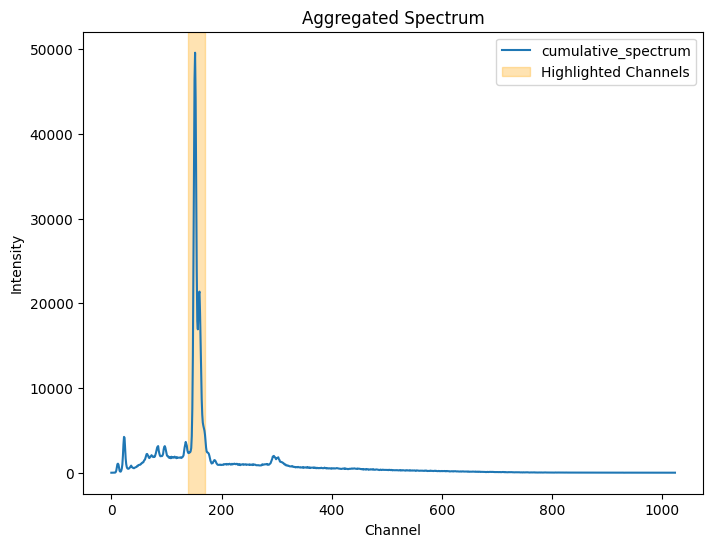

In [58]:
# Aggregate the spectrum for the bottom-right quadrant
cumulative_spectrum = np.sum(spectra_array2, axis=(0, 1))

# Plot the spectrum for the bottom-right quadrant
plt.figure(figsize=(8, 6))
plt.plot(cumulative_spectrum, label="cumulative_spectrum")

# Highlight the channels 150 to 180 with a semitransparent rectangle
plt.axvspan(140, 170, color='orange', alpha=0.3, label="Highlighted Channels")

plt.title("Aggregated Spectrum")
plt.xlabel("Channel")
plt.ylabel("Intensity")
plt.legend()
plt.show()

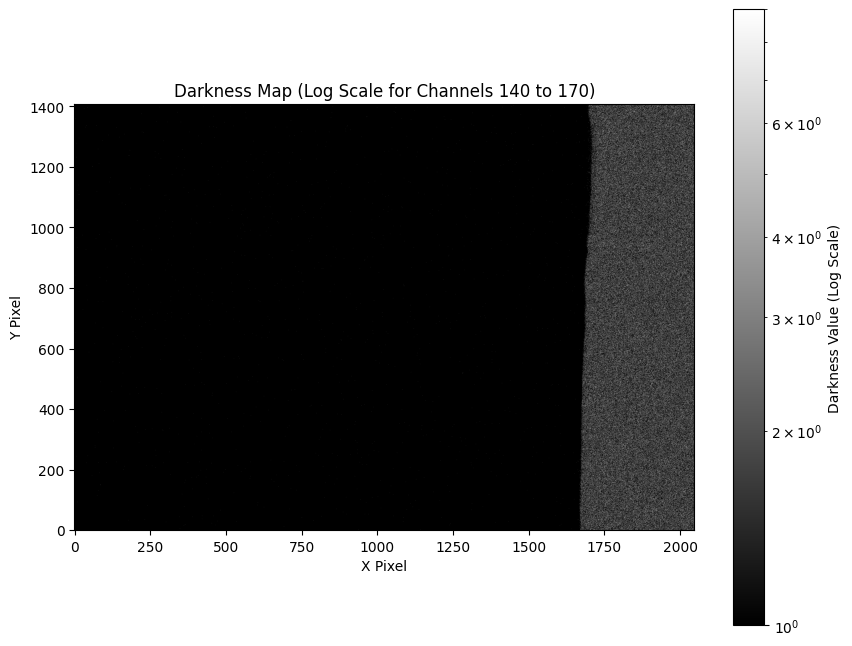

In [59]:
# Define the subset of channels (140 to 170 inclusive)
channel_start = 140
channel_end = 170

# Sum the counts across the subset of channels for every pixel
subset_sums = np.sum(spectra_array2[:, :, channel_start:channel_end + 1], axis=2)

# Normalize the sums to avoid zero values (Log scale requires positive values)
subset_sums = subset_sums + 1  # Add a small offset to avoid log(0)

# Plot the darkness map with a log scale
plt.figure(figsize=(10, 8))
plt.imshow(subset_sums, cmap="gray", norm=LogNorm(vmin=subset_sums.min(), vmax=subset_sums.max()), origin="lower")
plt.colorbar(label="Darkness Value (Log Scale)")
plt.title("Darkness Map (Log Scale for Channels 140 to 170)")
plt.xlabel("X Pixel")
plt.ylabel("Y Pixel")
plt.show()

In [69]:
file['/1/EDS/Header/Stage Position/X'][0]

65.65

In [70]:
file['/1/EDS/Header/Stage Position/Y'][0]

25.614

In [80]:
file['/1/EDS/Header/Stage Position/Z'][0]

10.57008

In [71]:
file['/1/EDS/Header/X Cells'][0]

2048

In [78]:
file['/1/EDS/Header/Y Cells'][0]

1408

In [77]:
file['/1/EDS/Header/X Step'][0]

0.3161621

In [79]:
file['/1/EDS/Header/Y Step'][0]

0.3161621

In [85]:
image_data = file['/1/Electron Image/Data/SE']
image_data

<HDF5 group "/1/Electron Image/Data/SE" (1 members)>

In [86]:
group_path = '/1/Electron Image/Data/SE'

# List all child keys in the group
children = list(file[group_path].keys())
print(f"Children of group '{group_path}': {children}")

# Access the first child (for example) if needed
first_child = children[0]
print(f"First child in group: {first_child}")

# Access data within the first child
data = file[group_path][first_child]
print(f"Data type: {type(data)}")
print(f"Data shape (if dataset): {getattr(data, 'shape', 'Not a dataset')}")

Children of group '/1/Electron Image/Data/SE': ['Electron Image 30']
First child in group: Electron Image 30
Data type: <class 'h5py._hl.dataset.Dataset'>
Data shape (if dataset): (720896,)


In [87]:
data

<HDF5 dataset "Electron Image 30": shape (720896,), type "<i2">

In [89]:
group_path = '/1/Electron Image/Data/SE'
first_child = list(file[group_path].keys())[0]  # Access the first child dynamically
data = file[group_path][first_child][:]  # Load the dataset as a NumPy array

In [91]:
data.shape

(720896,)

In [94]:
file['/1/Electron Image/Header/X Cells'][0]

1024

In [96]:
file['/1/Electron Image/Header/Y Cells'][0]

704

In [104]:
file['/1/Electron Image/Header/X Step'][0]

0.6323242

In [105]:
file['/1/Electron Image/Header/Y Step'][0]

0.6323242

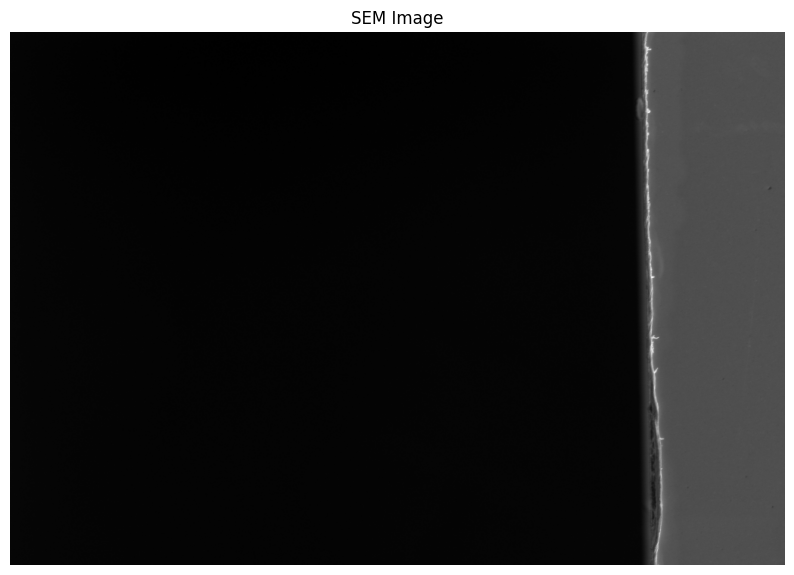

In [102]:
# Reshape the data using the correct dimensions (height = 1408, width = 2048)
width, height = 1024, 704  # Dimensions from your provided data
data_reshaped = data.reshape(height, width)

# Plot the reshaped image
plt.figure(figsize=(10, 7))  # Adjust figure size as needed
plt.imshow(data_reshaped, cmap='gray')  # Use a grayscale colormap for SEM images
plt.title('SEM Image')
plt.axis('off')  # Hide axes for better visualization
plt.show()

In [103]:
# Use plt's normalization for consistent appearance
fig, ax = plt.subplots()
im = ax.imshow(data_reshaped, cmap='gray')
plt.axis('off')  # Turn off the axes

# Save the image directly from the matplotlib figure
output_filename = "sem_image_match.jpg"
fig.savefig(output_filename, bbox_inches='tight', pad_inches=0, dpi=300)  # Adjust dpi for resolution
plt.close(fig)  # Close the figure to free up memory

print(f"Image saved as {output_filename} with appearance matching plt.imshow.")

Image saved as sem_image_match.jpg with appearance matching plt.imshow.


In [106]:
np.savez_compressed("data_reshaped.npz", data_reshaped)